In [5]:
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/45466947/include-output-from-matplotlib-notebook-backend-as-svg-in-ipynb
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import tempfile
import subprocess
import os
import json
from types import SimpleNamespace
from statistics import harmonic_mean

CWD = os.getcwd()
NS_PER_US = 1e3
print(f'Running in {CWD}.. this should be the project root folder!')

Running in /Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench.. this should be the project root folder!


In [6]:
def measure(samplerMod, sampleCmd, constNm, dataFile):
  with tempfile.NamedTemporaryFile(mode='w', suffix='.lean', encoding='utf-8') as f:
    f.write(f'''
      import bench.samplers.{samplerMod}
      import bench.measure
      set_option maxHeartbeats 0
      {sampleCmd}
      #measure {constNm} "{dataFile}" 0
    ''')
    f.flush()
    # os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH","")
    # env = os.environ.copy()
    # env["PATH"] = "/opt/homebrew/bin:" + env.get("PATH", "")
    # subprocess.run(["lake", "lean", f.name], cwd=CWD, env=env, check=True)
    subprocess.run(["lake", "lean", f.name], cwd="/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4")
    #subprocess.run(["/opt/homebrew/bin/lake", "lean", f.name], cwd=CWD)

In [39]:
N = 99
for i in range(N):
  # Measure the timing for each definition in a separate Lean process
  # to eliminate any potential cross-definition caching.
  measure('pair', f'#sample_pairs {N}', f'benchDef_pair_{i}', 'bench/2025_09_05_times_pair_cache.ndjson')
  measure('prod', f'#sample_prods {N}', f'benchDef_prod_{i}', 'bench/2025_09_05_times_prod_cache.ndjson')
  measure('id', f'#sample_ids {N}', f'benchDef_id_{i}', 'bench/2025_09_05_times_id_cache.ndjson')
  measure('fn', f'#sample_fns {N}', f'benchDef_fn_{i}', 'bench/2025_09_05_times_fn_cache.ndjson')

In [83]:
N = 499
for i in range(N):
  # Measure the timing for each definition in a separate Lean process
  # to eliminate any potential cross-definition caching.
  measure('id', f'#sample_ids {N}', f'benchDef_id_{i}', 'bench/2025_09_05_times_id_cache.ndjson')

In [73]:
data = {}
with open('/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_pair_cache.ndjson', 'r') as f:
  for line in f:
    obj = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
    # Prefers latest data when seeing multiple entries for the same definition
    data[obj.name] = obj

In [74]:
xs = [ ob.sz_val for ob in data.values() ]
ys = [ ob.t_kernel for ob in data.values() ]
rys = [ ob.t_rkernel_shared for ob in data.values() ]
(xs, ys, rs) = zip(*sorted(zip(xs, ys, rys)))

print(f'Kernel (deep) / kernel: {harmonic_mean([ry/y for (ry, y) in zip(rys, ys)])}')

Kernel (deep) / kernel: 3506.5719189319248


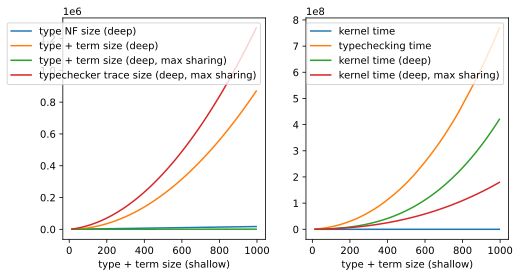

In [75]:
xs = [ ob.sz_val + ob.sz_tp for ob in data.values() ]
ys = [ ob.sz_deep_val + ob.sz_deep_tp for ob in data.values() ]
yss = [ ob.sz_deep_val_shared + ob.sz_deep_tp_shared for ob in data.values() ]
ts = [ ob.t_kernel for ob in data.values() ]
rs = [ ob.t_translate for ob in data.values() ]
cs = [ ob.t_typecheck for ob in data.values() ]
ns = [ ob.sz_deep_nfTp for ob in data.values() ]
ws = [ ob.sz_deep_wf_val for ob in data.values() ]
sws = [ ob.sz_deep_wf_val_shared for ob in data.values() ]
ks = [ ob.t_rkernel for ob in data.values() ]
kss = [ ob.t_rkernel_shared for ob in data.values() ]
vs = [ ob.sz_deep_val + ob.sz_deep_tp + ob.sz_deep_nfTp + ob.sz_deep_wf_nfTp + ob.sz_deep_wf_val for ob in data.values() ]
(xs, ys, yss, ts, rs, cs, ns, ws, sws, ks, kss, vs) = zip(*sorted(zip(xs, ys, yss, ts, rs, cs, ns, ws, sws, ks, kss, vs)))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

ax1.set_xlabel("type + term size (shallow)")
# constant in the id benchmark
ax1.plot(xs, ns, label="type NF size (deep)")
ax1.plot(xs, ys, label="type + term size (deep)")
ax1.plot(xs, yss, label="type + term size (deep, max sharing)")
# ax1.plot(xs, ws, label="typechecker trace size (deep)")
ax1.plot(xs, sws, label="typechecker trace size (deep, max sharing)")
# ax1.plot(xs, vs, label="value size (deep)")
ax1.legend()

ax2.set_xlabel("type + term size (shallow)")
ax2.plot(xs, ts, label="kernel time")
# ax2.plot(xs, rs, label="translation time")
ax2.plot(xs, cs, label="typechecking time")
ax2.plot(xs, ks, label="kernel time (deep)")
ax2.plot(xs, kss, label="kernel time (deep, max sharing)")
ax2.legend()


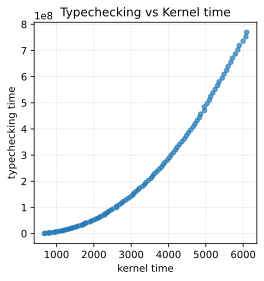

In [76]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)

ax.scatter(ts, cs, s=20, alpha=0.7)
ax.set_xlabel("kernel time")
ax.set_ylabel("typechecking time")
ax.set_title("Typechecking vs Kernel time")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)


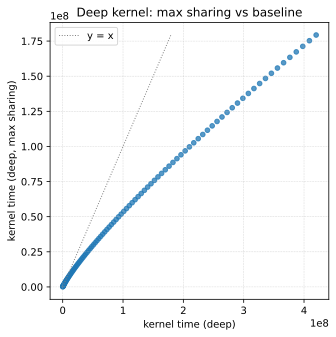

In [77]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

ax.scatter(ks, kss, s=22, alpha=0.75)
ax.set_xlabel("kernel time (deep)")
ax.set_ylabel("kernel time (deep, max sharing)")
ax.set_title("Deep kernel: max sharing vs baseline")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

# Optionally, plot y=x reference line to compare how close max sharing is to baseline:
import numpy as np
xmin, xmax = min(ks), max(kss)
ax.plot([xmin, xmax], [xmin, xmax], color="gray", linestyle=":", linewidth=1, label="y = x")
ax.legend()

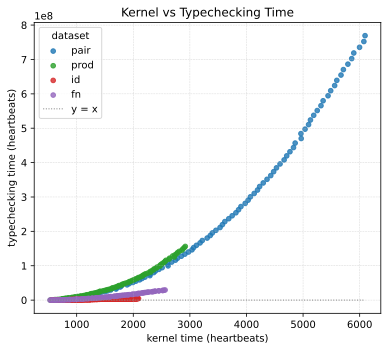

In [109]:
time_scale = 1

def load_ts_cs(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            ob = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
            # 只收集有完整字段的记录
            if hasattr(ob, "t_kernel") and hasattr(ob, "t_typecheck"):
                data.append((ob.t_kernel, ob.t_typecheck))
    if not data:
        return [], []
    ts, cs = zip(*data)
    return list(ts), list(cs)

files = [
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_pair_cache.ndjson", "pair"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_prod_cache.ndjson", "prod"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_id_cache.ndjson",   "id"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_fn_cache.ndjson",   "fn"),
]

colors = {
    "pair": "#1f77b4",
    "prod": "#2ca02c",
    "id":   "#d62728",
    "fn":   "#9467bd",
}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5.5, 5.0)


for path, label in files:
    ts, cs = load_ts_cs(path)
    if not ts:
        continue
    # 可选：做相同的排序（非必须）
    ts_sorted, cs_sorted = zip(*sorted(zip(ts, cs)))
    # 单位换算
    ts_plot = [t / time_scale for t in ts_sorted]
    cs_plot = [c / time_scale for c in cs_sorted]
    ax.scatter(ts_plot, cs_plot, s=22, alpha=0.8, label=label, color=colors.get(label, None))

# y = x 参考线（同一单位下才有意义）
if ax.collections:
    all_x = [x for coll in ax.collections for x in coll.get_offsets()[:,0]]
    xmin, xmax = min(all_x), max(all_x)
    ax.plot([xmin, xmax], [xmin, xmax], color="gray", linestyle=":", linewidth=1, label="y = x")

# 轴标签里注明单位
ax.set_xlabel("kernel time (heartbeats)")
ax.set_ylabel("typechecking time (heartbeats)")
ax.set_title("Kernel vs Typechecking Time")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.legend(title="dataset")
plt.tight_layout()

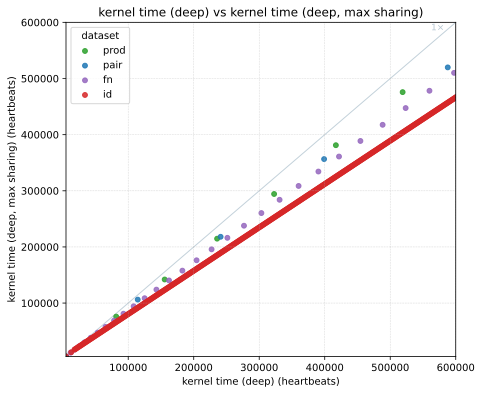

In [118]:
time_scale = 1
unit = "heartbeats"

def load_ts_cs(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            ob = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
            # 只收集有完整字段的记录
            if hasattr(ob, "t_kernel") and hasattr(ob, "t_typecheck"):
                data.append((ob.t_kernel, ob.t_typecheck))
    if not data:
        return [], []
    ts, cs = zip(*data)
    return list(ts), list(cs)

files = [
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_prod_cache.ndjson", "prod"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_pair_cache.ndjson", "pair"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_fn_cache.ndjson",   "fn"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_id_cache.ndjson",   "id"),
]

colors = {
    "prod": "#2ca02c",
    "pair": "#1f77b4",
    "fn":   "#9467bd",
    "id":   "#d62728"
}

# 需要叠加的等比线 y = kx
ratio_lines = [1]
ratio_color = "#afc1cd"  # 等比线颜色（浅蓝）
use_log = False           # 建议使用对数坐标，时间跨度大时更清晰

# ========= 工具函数 =========
def load_ts_cs(path):
    ts, cs = [], []
    with open(path, 'r') as f:
        for line in f:
            ob = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
            if hasattr(ob, "t_rkernel") and hasattr(ob, "t_rkernel_shared"):
                ts.append(ob.t_rkernel)
                cs.append(ob.t_rkernel_shared)
    return ts, cs

# ========= 加载数据 =========
datasets = {}
for path, label in files:
    ts_raw, cs_raw = load_ts_cs(path)
    if not ts_raw:
        continue
    # 排序仅为美观（按 x 增序），非必须
    ts_sorted, cs_sorted = zip(*sorted(zip(ts_raw, cs_raw)))
    ts_plot = np.array(ts_sorted, dtype=float)
    cs_plot = np.array(cs_sorted, dtype=float)
    datasets[label] = (ts_plot, cs_plot)

# ========= 绘图 =========
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6.8, 5.6)

# 散点
for label, (tx, ty) in datasets.items():
    ax.scatter(tx, ty, s=24, alpha=0.85, label=label, color=colors.get(label, None))

# 坐标尺度
if use_log:
    ax.set_xscale('log')
    ax.set_yscale('log')

# 设定边界并留白
if datasets:
    all_x = np.concatenate([v[0] for v in datasets.values()])
    all_y = np.concatenate([v[1] for v in datasets.values()])
    xmin, xmax = np.nanmin(all_x), np.nanmax(all_x)
    ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
    if use_log:
        ax.set_xlim(xmin * 0.8, xmax * 1.25)
        ax.set_ylim(ymin * 0.8, ymax * 1.25)
    else:
        ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.1 * (xmax - xmin))
        ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.1 * (ymax - ymin))


ax.set_xlim(xmin, 6e5)
ax.set_ylim(ymin, 6e5)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# 画等比线 y = kx，并把 “k×” 标注放到每条线的最右端
for k in ratio_lines:
    xs_line = np.array([xmin, xmax])
    ys_line = k * xs_line
    ax.plot(xs_line, ys_line, linestyle='-', color=ratio_color, linewidth=1, alpha=0.75, zorder=0)

    # 选择最右端的位置做标注，稍微向内偏移，避免越界
    x_tag = xmax / (1.03 if use_log else 1.03)  # 对数坐标下按比例缩一点，线性坐标下减小一个小比例
    y_tag = k * x_tag

    # 如果 y_tag 超出上边界，也向下拉回可见区域
    if y_tag >= ymax:
        # 在对数坐标下用比例，在线性坐标下用差值
        y_tag = ymax / 1.1

    ax.text(
        x_tag, y_tag, f"{k:g}×",
        color=ratio_color, fontsize=9,
        ha='right', va='bottom',
        alpha=0.9,
        rotation=0
    )

# 标题、轴标签、网格、图例
ax.set_xlabel(f"kernel time (deep) ({unit})")
ax.set_ylabel(f"kernel time (deep, max sharing) ({unit})")
ax.set_title("kernel time (deep) vs kernel time (deep, max sharing)")
ax.grid(True, which='both', linestyle="--", linewidth=0.5, alpha=0.5)
ax.legend(title="dataset", loc="best")



plt.tight_layout()
plt.show()

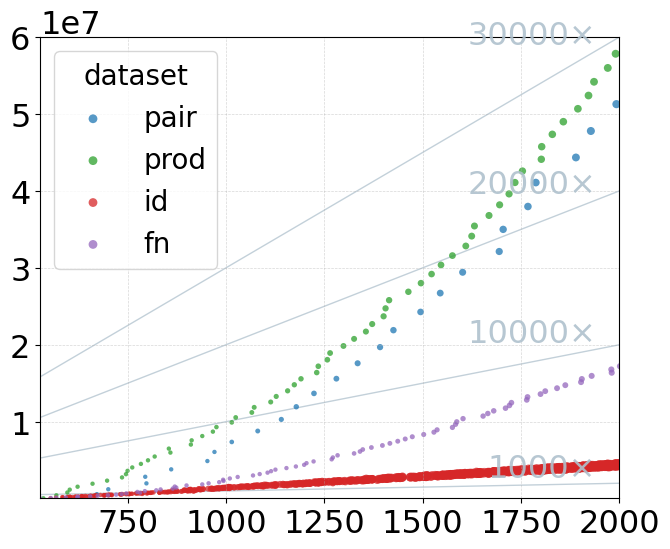

In [99]:
time_scale = 1
unit = "heartbeats"

files = [
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_pair_cache.ndjson", "pair"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_prod_cache.ndjson", "prod"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_id_cache.ndjson",   "id"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_fn_cache.ndjson",   "fn"),
]

colors = {
    "pair": "#1f77b4",
    "prod": "#2ca02c",
    "id":   "#d62728",
    "fn":   "#9467bd",
}

# 等比线
ratio_lines = [1000, 1e4, 2e4, 3e4]
ratio_color = "#afc1cd"
use_log = False

# ========== 工具函数：读取 x, y 与 size ==========
def load_xy_size(path):
    ts, cs, sizes = [], [], []
    with open(path, 'r') as f:
        for line in f:
            ob = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
            if hasattr(ob, "t_kernel") and hasattr(ob, "t_typecheck"):
                ts.append(ob.t_kernel / time_scale)
                cs.append(ob.t_typecheck / time_scale)
                # 若没有 sz_val/sz_tp 字段则给最小值 0
                sz_val = getattr(ob, "sz_val", 0)
                sz_tp  = getattr(ob, "sz_tp", 0)
                sizes.append(sz_val + sz_tp)
    return ts, cs, sizes

# ========== 加载数据 ==========
datasets = {}
for path, label in files:
    ts_raw, cs_raw, sz_raw = load_xy_size(path)
    if not ts_raw:
        continue
    # 排序（按 x）
    ts_sorted, cs_sorted, sz_sorted = zip(*sorted(zip(ts_raw, cs_raw, sz_raw)))
    datasets[label] = (
        np.array(ts_sorted, dtype=float),
        np.array(cs_sorted, dtype=float),
        np.array(sz_sorted, dtype=float),
    )

# 为了把“项大小”映射为散点面积，需要做缩放与裁剪
# 全局统计，便于统一尺度
if datasets:
    all_sizes = np.concatenate([v[2] for v in datasets.values()])
    # 处理极端值：用高分位做上限，避免少数点过大
    high = np.percentile(all_sizes, 99) if all_sizes.size else 1.0
    high = max(high, 1.0)
    # 防止全是零
    if np.all(all_sizes == 0):
        size_scale = 20.0  # 退化为常量大小
    else:
        # 把分位高值映射到可视范围（散点 s 是面积像素）
        target_area_at_high = 120.0  # 你可以调整：80~200 都可
        size_scale = target_area_at_high / high

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6.8, 5.6)

# 绘制散点（s 按 sz_val + sz_tp 缩放）
for label, (tx, ty, tz) in datasets.items():
    # 裁剪到上限，避免超大
    if np.any(tz):
        tz_clamped = np.minimum(tz, np.percentile(tz, 99))
        sizes = np.maximum(tz_clamped * size_scale, 10.0)  # 最小面积，避免太小看不见
    else:
        sizes = np.full_like(tz, 20.0)
    ax.scatter(tx, ty, s=sizes, alpha=0.75, label=label, color=colors.get(label, None), edgecolors='none')

# 坐标尺度
if use_log:
    ax.set_xscale('log')
    ax.set_yscale('log')

# 设定边界并留白
if datasets:
    all_x = np.concatenate([v[0] for v in datasets.values()])
    all_y = np.concatenate([v[1] for v in datasets.values()])
    xmin, xmax = np.nanmin(all_x), np.nanmax(all_x)
    ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
    if use_log:
        ax.set_xlim(xmin * 0.8, xmax * 1.25)
        ax.set_ylim(ymin * 0.8, ymax * 1.25)
    else:
        ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.1 * (xmax - xmin))
        ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.1 * (ymax - ymin))


ax.set_xlim(xmin, 2000)
ax.set_ylim(ymin, 0.6 * 1e8)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# 等比线与右端标注
for k in ratio_lines:
    xs_line = np.array([xmin, xmax])
    ys_line = k * xs_line
    ax.plot(xs_line, ys_line, linestyle='-', color=ratio_color, linewidth=1, alpha=0.75, zorder=0)

    x_tag = xmax / 1.03
    y_tag = k * x_tag
    if y_tag >= ymax:
        y_tag = ymax / 1.1
    ax.text(x_tag, y_tag, f"{k:g}×",
            color=ratio_color, fontsize=23,
            ha='right', va='bottom', alpha=0.9, rotation=0)

# 标题、轴标签、网格、图例
# ax.set_xlabel(f"kernel time ({unit})")
# ax.set_ylabel(f"typechecking time ({unit})")
# ax.set_title("Kernel vs Typechecking Time (bubble size = term size)")
ax.grid(True, which='both', linestyle="--", linewidth=0.5, alpha=0.5)
legend = ax.legend(title="dataset", loc="best", fontsize=20, title_fontsize=20)
for handle in legend.legend_handles:
    handle.set_sizes([40])

ax.tick_params(axis='both', which='major', labelsize=23)  # 设置主要刻度标签大小
ax.yaxis.get_offset_text().set_fontsize(23)

# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
# plt.subplots_adjust(left=0.08, right=0.97, bottom=0.12, top=0.95)
plt.tight_layout()
# plt.show()
plt.savefig('tt.pgf', backend='pgf')

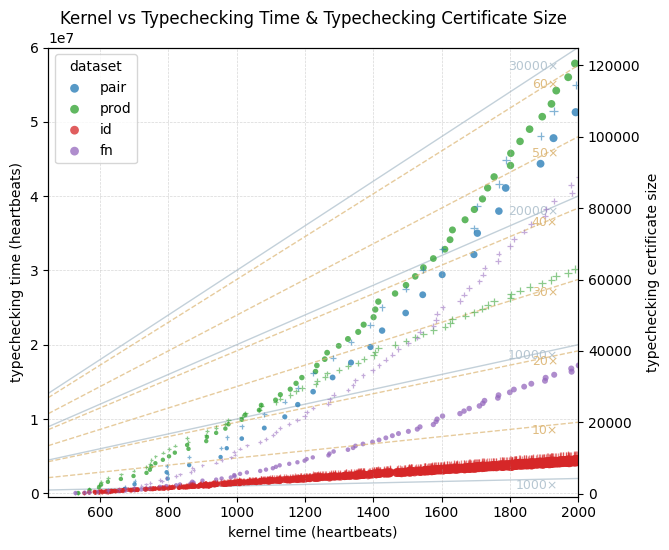

In [ ]:
time_scale = 1
unit = "heartbeats"

files = [
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_pair_cache.ndjson", "pair"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_prod_cache.ndjson", "prod"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_id_cache.ndjson",   "id"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_fn_cache.ndjson",   "fn"),
]

colors = {
    "pair": "#1f77b4",
    "prod": "#2ca02c",
    "id":   "#d62728",
    "fn":   "#9467bd",
}

# 等比线
ratio_lines = [1000, 1e4, 2e4, 3e4]
ratio_color = "#afc1cd"
use_log = False

# 右轴等比线（可与左轴一致，也可单独设置）
ratio_lines_right = [10, 20, 30, 40, 50, 60]
ratio_color_right = "#DCB57347"  # 与左轴区分的浅紫色

# 是否显示右侧 y 轴（证书大小）
right_axis_visible = True
right_marker = '+'
right_alpha = 0.55

# ========== 工具函数：读取 x, y 与 size、证书大小 ==========
def load_xy_size_cert(path):
    xs, ys, sizes, certs = [], [], [], []
    with open(path, 'r') as f:
        for line in f:
            ob = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
            if hasattr(ob, "t_kernel") and hasattr(ob, "t_typecheck"):
                xs.append(ob.t_kernel / time_scale)
                ys.append(ob.t_typecheck / time_scale)
                sz_val = getattr(ob, "sz_val", 0)
                sz_tp  = getattr(ob, "sz_tp", 0)
                sizes.append(sz_val + sz_tp)
                certs.append(getattr(ob, "sz_deep_wf_val_shared", None))
    return xs, ys, sizes, certs

# ========== 加载数据 ==========
datasets = {}
for path, label in files:
    xs_raw, ys_raw, sz_raw, cert_raw = load_xy_size_cert(path)
    if not xs_raw:
        continue
    # 按 x 排序（带上 size 与 cert）
    xs_sorted, ys_sorted, sz_sorted, cert_sorted = zip(*sorted(zip(xs_raw, ys_raw, sz_raw, cert_raw)))
    datasets[label] = (
        np.array(xs_sorted, dtype=float),   # x = kernel time
        np.array(ys_sorted, dtype=float),   # y_left = typechecking time
        np.array(sz_sorted, dtype=float),   # bubble size (term size)
        np.array(cert_sorted, dtype=float)  # y_right = certificate size (may contain nan)
    )

# 为了把“项大小”映射为散点面积，需要做缩放与裁剪
if datasets:
    all_sizes = np.concatenate([v[2] for v in datasets.values()])
    high = np.percentile(all_sizes, 99) if all_sizes.size else 1.0
    high = max(high, 1.0)
    if np.all(all_sizes == 0):
        size_scale = 20.0  # 退化为常量大小
    else:
        target_area_at_high = 120.0
        size_scale = target_area_at_high / high

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6.8, 5.6)

# 主散点（左轴）：气泡大小 = sz_val + sz_tp
for label, (tx, ty, tz, tcert) in datasets.items():
    if np.any(tz):
        tz_clamped = np.minimum(tz, np.percentile(tz, 99))
        sizes = np.maximum(tz_clamped * size_scale, 10.0)
    else:
        tz_clamped = tz  # 空数组时占位
        sizes = np.full_like(tz, 20.0)
    ax.scatter(tx, ty, s=sizes, alpha=0.75, label=label,
               color=colors.get(label, None), edgecolors='none')

# 可选右轴：证书大小（颜色与左轴一致；加号大小也基于 sz 映射）
if right_axis_visible:
    ax2 = ax.twinx()
    ax2.grid(False)  # 让右轴网格不干扰
    for label, (tx, ty, tz, tcert) in datasets.items():
        # 过滤缺失/NaN 的证书大小
        mask_cert = np.isfinite(tcert)
        if not np.any(mask_cert):
            continue

        # 使用与左轴一致的 size 映射：对 tz 进行相同的裁剪与缩放
        if np.any(tz):
            tz_clamped_local = np.minimum(tz, np.percentile(tz, 99))
            sizes_right = np.maximum(tz_clamped_local * size_scale, 6.0)  # 加号最小面积稍小
        else:
            sizes_right = np.full_like(tz, 10.0)

        # 仅绘制有证书数据的点
        ax2.scatter(
            tx[mask_cert], tcert[mask_cert],
            s=sizes_right[mask_cert],
            marker=right_marker,
            color=colors.get(label, "#666666"),
            alpha=right_alpha,
            linewidths=0.9
        )

# 坐标尺度
if use_log:
    ax.set_xscale('log')
    ax.set_yscale('log')
    if right_axis_visible:
        ax2.set_yscale('log')

# 设定边界并留白（针对左轴）
if datasets:
    all_x = np.concatenate([v[0] for v in datasets.values()])
    all_y_left = np.concatenate([v[1] for v in datasets.values()])
    xmin, xmax = np.nanmin(all_x), np.nanmax(all_x)
    ymin, ymax = np.nanmin(all_y_left), np.nanmax(all_y_left)
    if use_log:
        ax.set_xlim(xmin * 0.8, xmax * 1.25)
        ax.set_ylim(ymin * 0.8, ymax * 1.25)
    else:
        ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.1 * (xmax - xmin))
        ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.1 * (ymax - ymin))

# 固定范围（左轴）
ax.set_xlim(xmin-80, 2000)
ax.set_ylim(ymin-5e5, 0.6 * 1e8)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# 右轴范围（自动适配证书大小或手动上限）
if right_axis_visible:
    all_cert = np.concatenate([v[3][np.isfinite(v[3])] for v in datasets.values() if np.any(np.isfinite(v[3]))]) if datasets else np.array([])
    if all_cert.size:
        cmin, cmax = float(np.nanmin(all_cert)), float(np.nanmax(all_cert))
        if cmin == cmax:
            cmin = max(0.0, cmin - 1.0)
            cmax = cmax + 1.0
        # 这里沿用你之前的固定上限示例，也可用自动留白：
        # ax2.set_ylim(cmin - 0.05 * (cmax - cmin), cmax + 0.1 * (cmax - cmin))
        ax2.set_ylim(cmin - 1000, 125000)

# 等比线（左轴，y = kx）
for k in ratio_lines:
    xs_line = np.array([xmin, xmax])
    ys_line = k * xs_line
    ax.plot(xs_line, ys_line, linestyle='-', color=ratio_color, linewidth=1, alpha=0.75, zorder=0)
    x_tag = xmax / 1.03
    y_tag = k * x_tag
    if y_tag >= ymax:
        y_tag = ymax / 1.2
    ax.text(x_tag, y_tag, f"{k:g}×",
            color=ratio_color, fontsize=9,
            ha='right', va='top', alpha=0.9, rotation=0)

# 右轴等比线（y_right = k * x）
if right_axis_visible:
    for k in ratio_lines_right:
        xs_line = np.array([xmin, xmax])
        ys_line_r = k * xs_line
        # 只在右轴可见范围内绘制
        ax2.plot(xs_line, ys_line_r, linestyle='--', color=ratio_color_right, linewidth=1, alpha=0.7, zorder=0)
        # 右侧标注
        x_tag_r = xmax / 1.03
        y_tag_r = k * x_tag_r
        if y_tag_r >= cmax:
            y_tag_r = cmax / 1.1
        ax2.text(x_tag_r, y_tag_r, f"{k:g}×",
                 color=ratio_color_right, fontsize=9,
                 ha='right', va='top', alpha=0.9)

# 轴标签与标题
ax.set_xlabel(f"kernel time ({unit})")
ax.set_ylabel(f"typechecking time ({unit})")
if right_axis_visible:
    ax2.set_ylabel("typechecking certificate size")

ax.set_title("Kernel vs Typechecking Time & Typechecking Certificate Size")

# 网格与图例（图例仅来自左轴，右轴不重复进入图例）
ax.grid(True, which='both', linestyle="--", linewidth=0.5, alpha=0.5)
legend = ax.legend(title="dataset", loc="best")
for handle in legend.legend_handles:
    handle.set_sizes([40])  # 统一图例标记大小

plt.tight_layout()
plt.show()

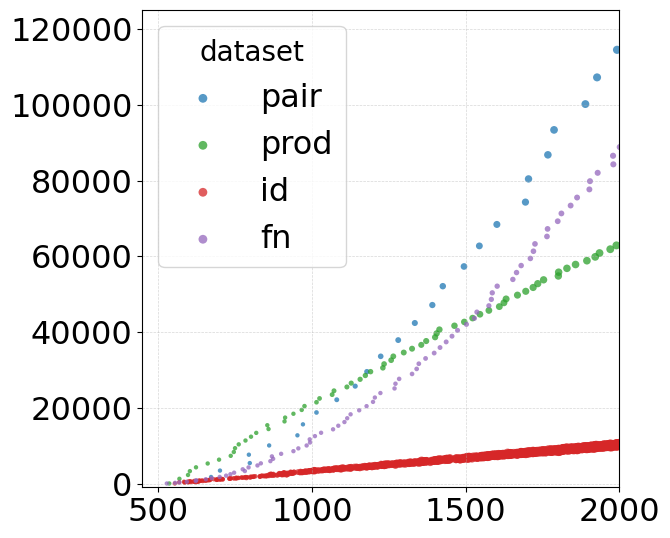

In [100]:
time_scale = 1
unit = "heartbeats"

files = [
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_pair_cache.ndjson", "pair"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_prod_cache.ndjson", "prod"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_id_cache.ndjson",   "id"),
    ("/Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench/2025_09_05_times_fn_cache.ndjson",   "fn"),
]

colors = {
    "pair": "#1f77b4",
    "prod": "#2ca02c",
    "id":   "#d62728",
    "fn":   "#9467bd",
}

# 等比线
ratio_lines = [1, 10, 20, 30, 40, 50, 60]
ratio_color = "#afc1cd"
use_log = False

# ========== 工具函数：读取 x, y 与 size ==========
def load_xy_size(path):
    ts, cs, sizes = [], [], []
    with open(path, 'r') as f:
        for line in f:
            ob = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
            if hasattr(ob, "t_kernel") and hasattr(ob, "sz_deep_wf_val_shared"):
                ts.append(ob.t_kernel / time_scale)
                cs.append(ob.sz_deep_wf_val_shared / time_scale)
                # 若没有 sz_val/sz_tp 字段则给最小值 0
                sz_val = getattr(ob, "sz_val", 0)
                sz_tp  = getattr(ob, "sz_tp", 0)
                sizes.append(sz_val + sz_tp)
    return ts, cs, sizes

# ========== 加载数据 ==========
datasets = {}
for path, label in files:
    ts_raw, cs_raw, sz_raw = load_xy_size(path)
    if not ts_raw:
        continue
    # 排序（按 x）
    ts_sorted, cs_sorted, sz_sorted = zip(*sorted(zip(ts_raw, cs_raw, sz_raw)))
    datasets[label] = (
        np.array(ts_sorted, dtype=float),
        np.array(cs_sorted, dtype=float),
        np.array(sz_sorted, dtype=float),
    )

# 为了把“项大小”映射为散点面积，需要做缩放与裁剪
# 全局统计，便于统一尺度
if datasets:
    all_sizes = np.concatenate([v[2] for v in datasets.values()])
    # 处理极端值：用高分位做上限，避免少数点过大
    high = np.percentile(all_sizes, 99) if all_sizes.size else 1.0
    high = max(high, 1.0)
    # 防止全是零
    if np.all(all_sizes == 0):
        size_scale = 20.0  # 退化为常量大小
    else:
        # 把分位高值映射到可视范围（散点 s 是面积像素）
        target_area_at_high = 120.0  # 你可以调整：80~200 都可
        size_scale = target_area_at_high / high

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6.8, 5.6)

# 绘制散点（s 按 sz_val + sz_tp 缩放）
for label, (tx, ty, tz) in datasets.items():
    # 裁剪到上限，避免超大
    if np.any(tz):
        tz_clamped = np.minimum(tz, np.percentile(tz, 99))
        sizes = np.maximum(tz_clamped * size_scale, 10.0)  # 最小面积，避免太小看不见
    else:
        sizes = np.full_like(tz, 20.0)
    ax.scatter(tx, ty, s=sizes, alpha=0.75, label=label, color=colors.get(label, None), edgecolors='none')

# 坐标尺度
if use_log:
    ax.set_xscale('log')
    ax.set_yscale('log')

# 设定边界并留白
if datasets:
    all_x = np.concatenate([v[0] for v in datasets.values()])
    all_y = np.concatenate([v[1] for v in datasets.values()])
    xmin, xmax = np.nanmin(all_x), np.nanmax(all_x)
    ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
    if use_log:
        ax.set_xlim(xmin * 0.8, xmax * 1.25)
        ax.set_ylim(ymin * 0.8, ymax * 1.25)
    else:
        ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.1 * (xmax - xmin))
        ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.1 * (ymax - ymin))


ax.set_xlim(xmin-80, 2000)
ax.set_ylim(ymin - 1000, 125000)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# 等比线与右端标注
# for k in ratio_lines:
#     xs_line = np.array([xmin, xmax])
#     ys_line = k * xs_line
#     ax.plot(xs_line, ys_line, linestyle='-', color=ratio_color, linewidth=1, alpha=0.75, zorder=0)

#     x_tag = xmax / 1.03
#     y_tag = k * x_tag
#     if y_tag >= ymax:
#         y_tag = ymax / 1.1
#     ax.text(x_tag, y_tag, f"{k:g}×",
#             color=ratio_color, fontsize=9,
#             ha='right', va='top', alpha=0.9, rotation=0)

# 标题、轴标签、网格、图例
# ax.set_xlabel(f"kernel time ({unit})")
# ax.set_ylabel(f"typechecking certificate size")
# ax.set_title("Kernel vs Typechecking Certificate Size (bubble size = term size)")
ax.grid(True, which='both', linestyle="--", linewidth=0.5, alpha=0.5)
legend = ax.legend(title="dataset", loc="best", fontsize=23, title_fontsize=20)
for handle in legend.legend_handles:
    handle.set_sizes([40])

ax.tick_params(axis='both', which='major', labelsize=23)  # 设置主要刻度标签大小

plt.tight_layout()

# import tikzplotlib
# tikzplotlib.save("mytikz.tex")

plt.savefig('tcs.pgf', backend='pgf')
#plt.show()